# Advisory report draft
___
<pre>Teamname    : Submission Impossible 💥  
group nr    : 32C  
Students    : {Andrei Dragomir, Ece Doganer, Márk Kerekes, Ariana Vargas Pastor}  
Student nrs : {2669304, 2552855, [], []}  </pre>
___

In this notebook you will find:
1. Data exploration together with its visualization
2. Modelling a Neural Network with single hidden layer and no drop-out on the data
3. Model evaluation and understanding

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

### Part 1: Exploration

Visually explore the dataset, to get a feel for the information content and distributions of its features, and correlations between them. Visualise the data for your company, compared to overall population. What percentage of candidates is hired? How does this differ over gender, age, nationality, sports? 

We are expecting that higher degrees and higher university grade to have a higher impact on the success rate of candidates as well as the fact that they have received their degrees in the same field of interest as the company.

In [226]:
#Importing the dataset
recruitmentData = pd.read_csv (r'recruitmentdataset-2022-1.3.csv')
print(recruitmentData)

          Id  gender  age nationality     sport  ind-university_grade  \
0     x8011e  female   24      German  Swimming                    70   
1     x6077a    male   26      German      Golf                    67   
2     x6006e  female   23       Dutch   Running                    67   
3     x2173b    male   24       Dutch   Cricket                    70   
4     x6241a  female   26      German      Golf                    59   
...      ...     ...  ...         ...       ...                   ...   
3995  x7640e  female   28       Dutch   Running                    63   
3996  x3310f  female   27       Dutch    Tennis                    62   
3997  x1202g    male   24     Belgian     Rugby                    60   
3998  x1263d  female   22       Dutch    Tennis                    66   
3999  x2396a    male   28       Dutch  Football                    58   

      ind-debateclub  ind-programming_exp  ind-international_exp  \
0              False                False              

#### Demographic based analysis

In this section we take into consideration the distribution of candidates based on _gender_ and _nationality_ and the difference in approval rates based on these traits.

Observations:
1. We can observe that the majority of the candidates are of Dutch nationality;
2. We can observe that in all cases, the number of male candidates is higher than the female ones as well as the others;
3. We can observe that the positive decision rate is highest for male candidates which does not show much in itself given that the number of male candidates is considerably higher but more observations are made in the following sections

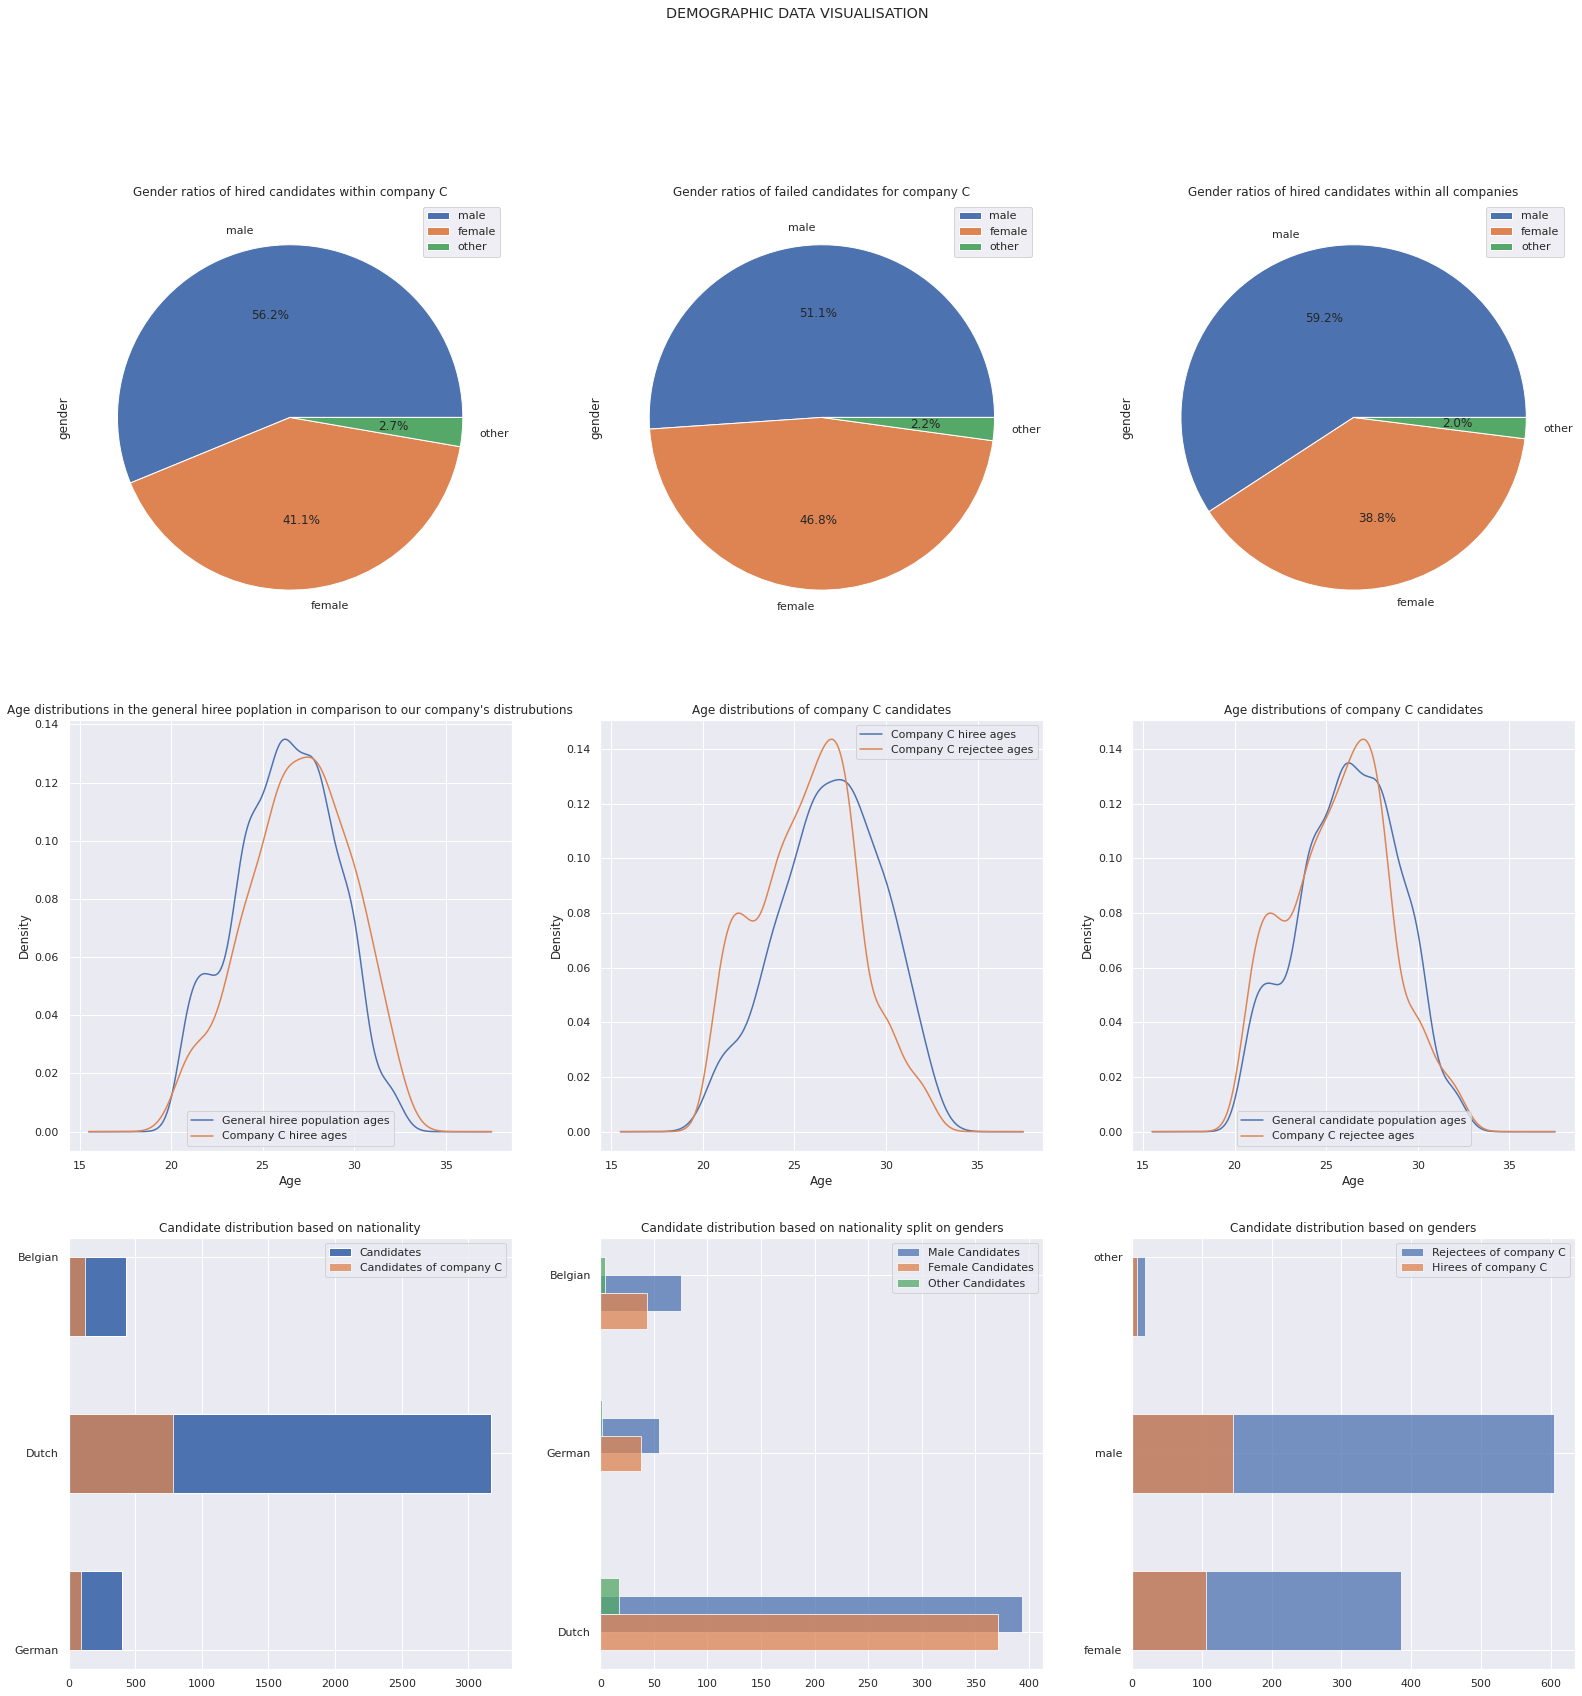

In [227]:
from cProfile import label

demographicDataFrame = pd.DataFrame(recruitmentData, columns = ['nationality', 'gender', 'decision', 'age', 'company'])

#TODO Visualize differences between demographic distribution of hired candidates in our company as opposed to the general hired population;
#     Every candidate that applied to our company compared with the company's hired population. - Andrei
# It is shown how the hired population of your company differs from the hired population overall and the population that applied to your company


fig1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3)
fig1.suptitle('DEMOGRAPHIC DATA VISUALISATION')
fig1.set_figwidth(27)
fig1.set_figheight(27)

#First plot
demographicDataFrame.query("company == 'C' and decision == True")['gender'].value_counts().plot.pie(ax=ax1, labels=['male', 'female', 'other'], autopct='%1.1f%%')
ax1.set_title("Gender ratios of hired candidates within company C")
ax1.legend()

#Second plot
demographicDataFrame.query("company == 'C' and decision != True")['gender'].value_counts().plot.pie(ax=ax2, labels=['male', 'female', 'other'], autopct='%1.1f%%')
ax2.set_title("Gender ratios of failed candidates for company C")
ax2.legend()

#Third plot
demographicDataFrame.query("decision == True")['gender'].value_counts().plot.pie(ax=ax3, labels=['male', 'female', 'other'], autopct='%1.1f%%')
ax3.set_title("Gender ratios of hired candidates within all companies")
ax3.legend()

#Fourth plot
demographicDataFrame.query("decision and company != 'C'")['age'].plot(kind='density', ax=ax4, label="General hiree population ages")
demographicDataFrame.query("decision and company == 'C'")['age'].plot(kind='density', ax=ax4, label="Company C hiree ages")
ax4.set_xlabel("Age")
ax4.set_title("Age distributions in the general hiree poplation in comparison to our company's distrubutions")
ax4.legend()

#Fifth plot
demographicDataFrame.query("decision and company == 'C'")['age'].plot(kind='density', ax=ax5, label="Company C hiree ages")
demographicDataFrame.query("not decision and company == 'C'")['age'].plot(kind='density', ax=ax5, label="Company C rejectee ages")
ax5.set_xlabel("Age")
ax5.set_title("Age distributions of company C candidates")
ax5.legend()

#Sixth plot
demographicDataFrame.query("decision and company != 'C'")['age'].plot(kind='density', ax=ax6, label="General candidate population ages")
demographicDataFrame.query("not decision and company == 'C'")['age'].plot(kind='density', ax=ax6, label="Company C rejectee ages")
ax6.set_xlabel("Age")
ax6.set_title("Age distributions of company C candidates")
ax6.legend()

#Seventh plot
ax7.hist(demographicDataFrame['nationality'], label = 'Candidates', bins = 5, orientation='horizontal')
ax7.hist(demographicDataFrame.query("company == 'C'")['nationality'], bins = 5, label = 'Candidates of company C', orientation='horizontal', alpha = 0.75)
ax7.set_title("Candidate distribution based on nationality")
ax7.legend()

#Eighth plot
ax8.hist(demographicDataFrame.query("gender == 'male' and company == 'C'")['nationality'], label='Male Candidates', orientation='horizontal', align='mid', alpha= 0.75)
ax8.hist(demographicDataFrame.query("gender == 'female' and company == 'C'")['nationality'], label='Female Candidates', orientation='horizontal', align='left', alpha= 0.75)
ax8.hist(demographicDataFrame.query("gender == 'other' and company == 'C'")['nationality'], label='Other Candidates', orientation='horizontal', align='right', alpha= 0.75)
ax8.set_title("Candidate distribution based on nationality split on genders")
ax8.legend()



#Ninth plot
ax9.hist(demographicDataFrame.query("decision and company != 'C'")['gender'], bins = 5, label = 'Rejectees of company C', orientation='horizontal', alpha = 0.75)
ax9.hist(demographicDataFrame.query("decision and company == 'C'")['gender'], label = 'Hirees of company C', bins = 5, orientation='horizontal', alpha=0.75)
ax9.set_title("Candidate distribution based on genders")
ax9.legend()




Based on the following calculations, the success rate of male candidates is significantly higher than female success rate, thus, we can consider gender to be a feature of interest in our model traning.

In [228]:
maleDataFrame = demographicDataFrame.query("gender == 'male' and company == 'C'")
maleSuccessRate = (maleDataFrame[maleDataFrame['decision']].value_counts()/ maleDataFrame['decision'].count()) * 100

femaleDataFrame = demographicDataFrame.query("gender == 'female' and company == 'C'")
femaleSuccessRate = (femaleDataFrame[femaleDataFrame['decision']].value_counts()/ femaleDataFrame['decision'].count()) * 100

otherDataFrame = demographicDataFrame.query("gender == 'other' and company == 'C'")
otherSuccessRate = (otherDataFrame[otherDataFrame['decision']].value_counts()/ otherDataFrame['decision'].count()) * 100

print("Male cummulative success rate: " + str(maleSuccessRate.sum()))
print("Female cummulative success rate: " + str(femaleSuccessRate.sum()))
print("Others cummulative success rate: " + str(otherSuccessRate.sum()))

Male cummulative success rate: 27.67175572519084
Female cummulative success rate: 23.399558498896248
Others cummulative success rate: 30.434782608695656


The following section will focus on the analysis of professional and academic levels of the candidates and how that affects their success rate

(45.0, 80.0)

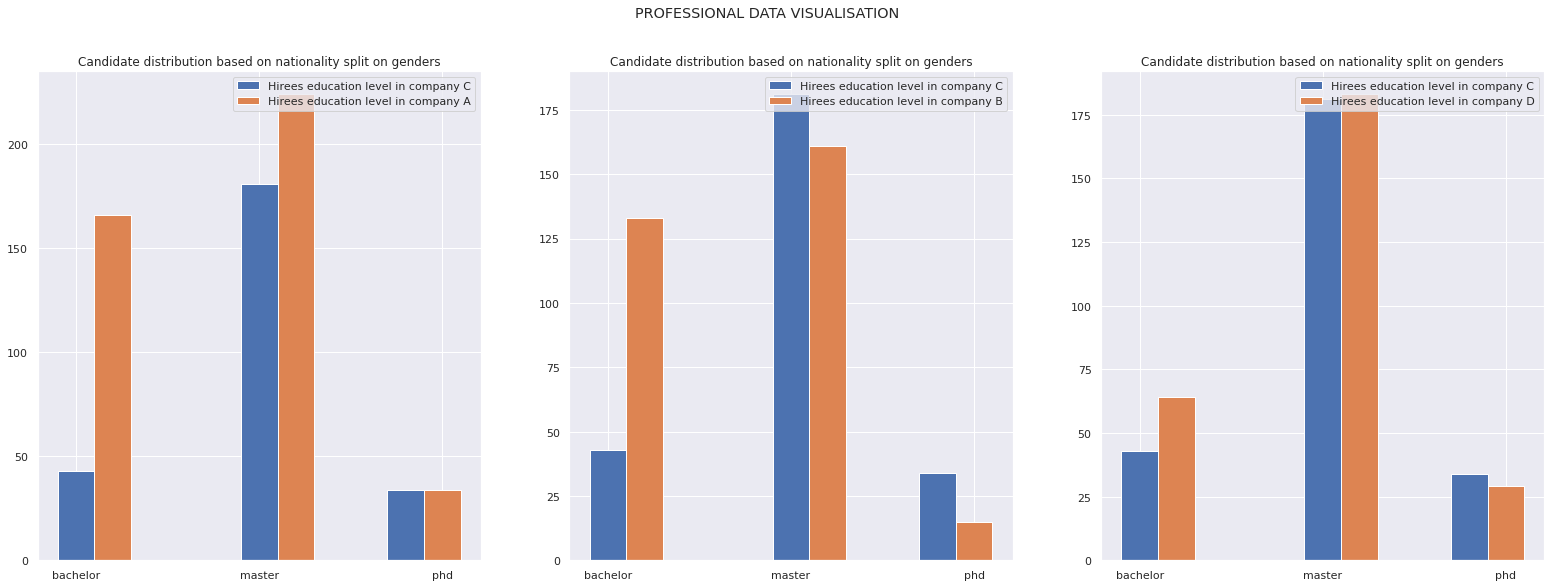

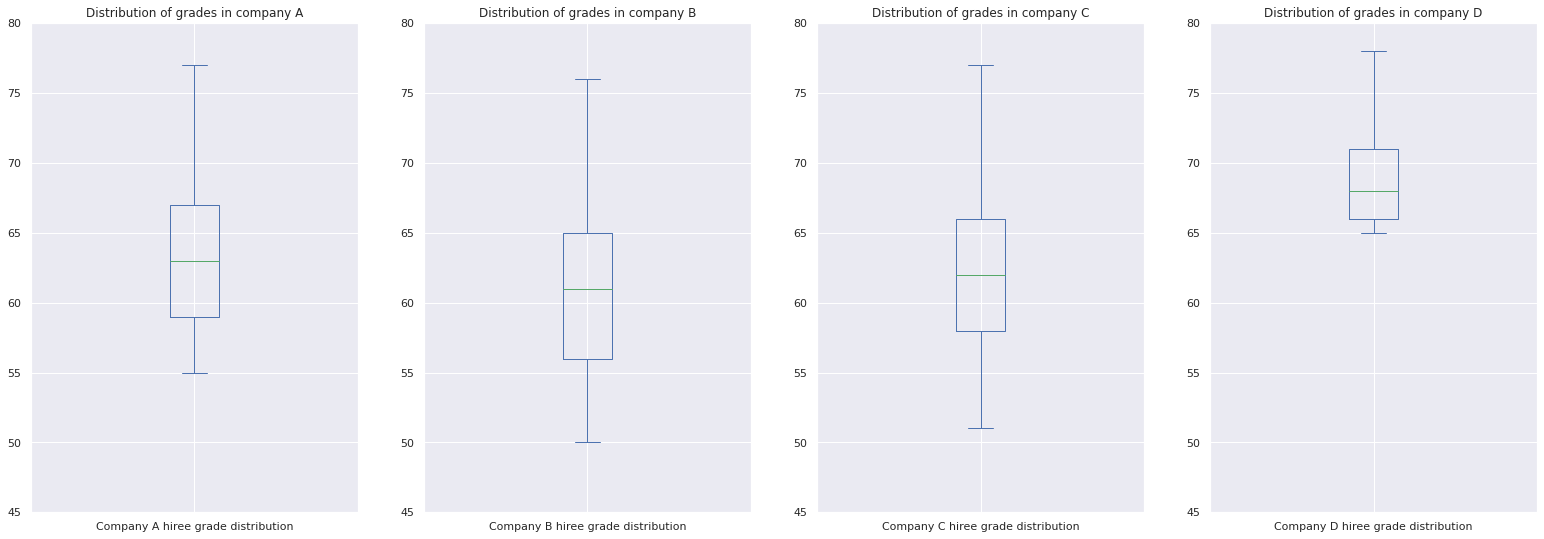

In [229]:
professionalDataFrame = pd.DataFrame(recruitmentData, columns = ['ind-exact_study', 'ind-university_grade', 'ind-programming_experience', 'ind-degree', 'decision', 'company'])

professionalDataFrame.rename(columns={'ind-university_grade': 'grade', 'ind-programming_experience': 'experience', 'ind-degree': 'degree', 'ind-exact_study' : 'study'}, inplace=True)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.suptitle('PROFESSIONAL DATA VISUALISATION')
fig.set_figwidth(27)
fig.set_figheight(9)

ax1.hist(professionalDataFrame.query("decision and company == 'C'")['degree'], align='left', label="Hirees education level in company C")
ax1.hist(professionalDataFrame.query("decision and company == 'A'")['degree'], align='right', label="Hirees education level in company A")
ax1.set_title("Candidate distribution based on nationality split on genders")
ax1.legend()

ax2.hist(professionalDataFrame.query("decision and company == 'C'")['degree'], align='left',label="Hirees education level in company C")
ax2.hist(professionalDataFrame.query("decision and company == 'B'")['degree'], align='right',label="Hirees education level in company B")
ax2.set_title("Candidate distribution based on nationality split on genders")
ax2.legend()

ax3.hist(professionalDataFrame.query("decision and company == 'C'")['degree'], align='left', label="Hirees education level in company C")
ax3.hist(professionalDataFrame.query("decision and company == 'D'")['degree'], align='right', label="Hirees education level in company D")
ax3.set_title("Candidate distribution based on nationality split on genders")
ax3.legend()

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4)
fig.set_figwidth(27)
fig.set_figheight(9)

professionalDataFrame.query("decision and company == 'A'")['grade'].plot(kind='box', ax=ax1, label="Company A hiree grade distribution")
ax1.set_title("Distribution of grades in company A")
ax1.set_ylim(45,80)

professionalDataFrame.query("decision and company == 'B'")['grade'].plot(kind='box', ax=ax2, label="Company B hiree grade distribution")
ax2.set_title("Distribution of grades in company B")
ax2.set_ylim(45,80)

professionalDataFrame.query("decision and company == 'C'")['grade'].plot(kind='box', ax=ax3, label="Company C hiree grade distribution")
ax3.set_title("Distribution of grades in company C")
ax3.set_ylim(45,80)

professionalDataFrame.query("decision and company == 'D'")['grade'].plot(kind='box', ax=ax4, label="Company D hiree grade distribution")
ax4.set_title("Distribution of grades in company D")
ax4.set_ylim(45,80)



In [239]:
#Explicit grade distribution and statistical information also shown in the first box plot above
professionalDataFrame.query("decision and company == 'C'")['grade'].describe()


,nationality,gender,decision,age,company


Correlations between the different predictors and between the predictors and indicators

<AxesSubplot:>

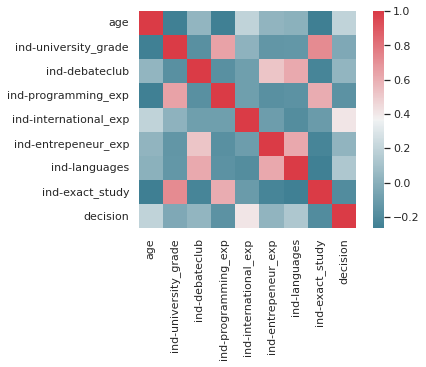

In [231]:
df = pd.DataFrame(recruitmentData, columns = ["Id", "gender", "age", "nationality", "sport", "ind-university_grade", "ind-debateclub", "ind-programming_exp", "ind-international_exp", "ind-entrepeneur_exp", "ind-languages", "ind-exact_study", "ind-degree", "company", "decision"])
df_C = df[df["company"] == 'C']
corr = df_C.corr()
seaborn.heatmap(corr, mask=np.zeros_like(corr), cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
            square=True)

Ranking for the predictive power of the indicators

In [232]:
ranking = corr['decision']
ranking = ranking.sort_values()
ranking.name = "Ranking of the predictive power of indicators"
print(ranking)

ind-exact_study         -0.194558
ind-programming_exp     -0.159530
ind-university_grade    -0.037285
ind-entrepeneur_exp      0.027853
ind-debateclub           0.033267
ind-languages            0.132866
age                      0.194080
ind-international_exp    0.406178
decision                 1.000000
Name: Ranking of the predictive power of indicators, dtype: float64


### M1: Neural Network with a single hidden layer and no drop-out

(apparently we are competing with other groups in terms of accuracy/.../...)

TODO: intro txt here, signalling what to expect

#### Splitting the data
TODO: explain how we decided to split the data (generalisation and regularisation),

#### Best 4 indicators 
TODO: explain best choice for indicators (test other sets of indicators)

#### 3 vs 4 vs 5 indicators
TODO: explain choice for 4 indicators opposed to 3 and 5 (testing again sets of indicators) (make sure to note explainability of 4 indicators)

#### Tuning hyperparameters

TODO: explain how the vars determining learning rate and number of hidden units are optimal for our our model, by showing different hyperparameters